In [1]:
from Testing_Stacks import *

In [2]:
Aug_ConvLSTM_model = AugementedConvLSTM(
    projection_height = 129, 
    projection_width = 135,
    timesteps=4
    )
model = Aug_ConvLSTM_model.model(
    [32, 16, 16], 
    [9,5,3], 
    [64,32,1], 
    [9,3,5], 
    2
    )

2022-06-13 04:40:34.316728: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-13 04:40:37.105889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9631 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:18:00.0, compute capability: 7.5
2022-06-13 04:40:37.107626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9631 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-06-13 04:40:37.109206: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/r

In [3]:
model.load_weights('convlstm_weights_pr.h5')

In [10]:
def load_dataset(gcm = None, case = None, y = None):
    X = np.load(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/Tuning_weights/Stacked/X_{gcm}_{case}.npy")
    Y = np.load(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/Tuning_weights/Stacked/{y}.npy")
    return X,Y

In [8]:
def get_yy_hat(model_name, model, case, y):
    X, Y = load_dataset(model_name, case, y)
    X, Y, std_observed = set_data(X, Y)
    generator = data_generator(X,Y)
    for xx, yy in itertools.islice(generator, 0, 1, 1):
        print(xx.shape, yy.shape)
    yy_hat = model.predict(generator)
    print(yy_hat.shape)
    np.save(rf"npy_Files/yy_hat_{model_name}_{case}.npy", yy_hat)

In [12]:
from tqdm import tqdm
def get_RMSE(model_name, case, y):
    X, Y = load_dataset(model_name, case, y)
    X, Y, std_observed = set_data(X, Y)
    generator = data_generator(X,Y)
    yy_hat = np.load(rf"npy_Files/yy_hat_{model_name}_{case}.npy")
    rmse = np.zeros((129,135))
    rmse_hist = np.zeros((yy_hat.shape[0],129,135))
    cnt = 0
    for xx, yy in tqdm(itertools.islice(generator, 0, None, 1)):
        yy_pred = yy_hat[cnt].reshape(129,135)
        yy = yy.reshape(129,135)
        rmse += np.square(yy - yy_pred)
        cnt += 1
        rmse_hist[cnt-1] = np.sqrt(rmse/cnt)
    rmse = np.sqrt(rmse/cnt)
    np.save(rf"npy_Files/rmse_hist_{model_name}_{case}.npy", rmse_hist)
    plot_RMSE(model_name, case)
    
def plot_RMSE(model_name, case):
    rmse = np.load(rf"npy_Files/rmse_hist_{model_name}_{case}.npy")[-1]
    FileName = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/SRTM.npy"
    mask = np.load(FileName)
    indices = np.where(mask == 0)
    rmse[indices] = np.nan
    fig,ax = plt.subplots(1,2, figsize = (20,10))
    # plt.imshow(plt.imread('tt_India.png'), zorder = 3)
    # sns.heatmap(np.flip(rmse, axis = 0), cmap = 'Greys', ax =ax[0], vmin = 0, vmax = 15)
    sns.heatmap(np.flip(rmse, axis = 0), cmap = 'rainbow', ax =ax[0])
    # ax.set_facecolor("lightgray")
    ax[0].axis('off')
    ax[1].boxplot(rmse[~np.isnan(rmse)], vert = False)
    plt.suptitle(f"{model_name} : RMSE Plot", fontsize = 16)


In [11]:
get_yy_hat('MIROC-ESM', model, 'monsoon', 'Y_monsoon')

Mean of GCM Data:  7.361372669007257e-05
Variance of GCM Data:  9.168313223684433e-05
Mean of Obseved Data:  1.7105762063791383
Variance of Obseved Data:  8.331053497927144
(1, 4, 129, 135, 7) (1, 129, 135, 1)


2022-06-13 04:43:40.273778: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 7605
2022-06-13 04:43:41.405732: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2022-06-13 04:43:41.981196: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


(8870, 129, 135, 1)


Mean of GCM Data:  7.361372669007257e-05
Variance of GCM Data:  9.168313223684433e-05
Mean of Obseved Data:  1.7105762063791383
Variance of Obseved Data:  8.331053497927144


8870it [00:13, 651.68it/s]


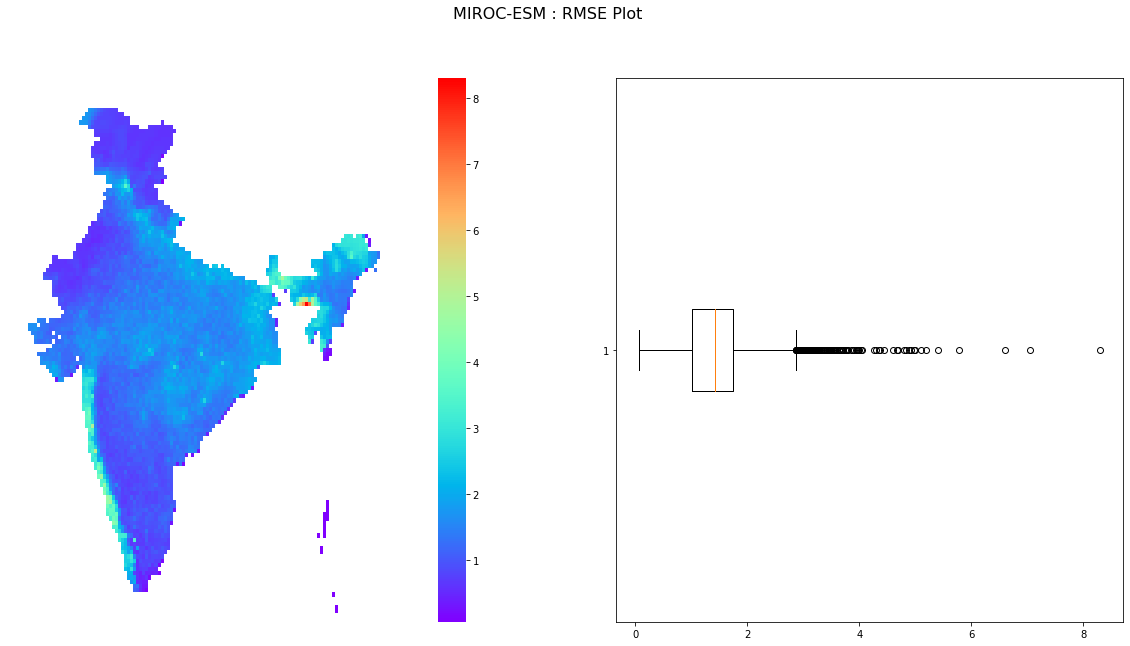

In [13]:
get_RMSE('MIROC-ESM', 'monsoon', 'Y_monsoon')

In [14]:
get_yy_hat('MIROC-ESM', model, 'non_monsoon', 'Y_non_monsoon')

Mean of GCM Data:  1.9885217862968148e-05
Variance of GCM Data:  4.613610011041244e-05
Mean of Obseved Data:  0.304267144337946
Variance of Obseved Data:  3.0315711672038255
(1, 4, 129, 135, 7) (1, 129, 135, 1)
(12292, 129, 135, 1)


Mean of GCM Data:  1.9885217862968148e-05
Variance of GCM Data:  4.613610011041244e-05
Mean of Obseved Data:  0.304267144337946
Variance of Obseved Data:  3.0315711672038255


12292it [00:26, 468.18it/s]


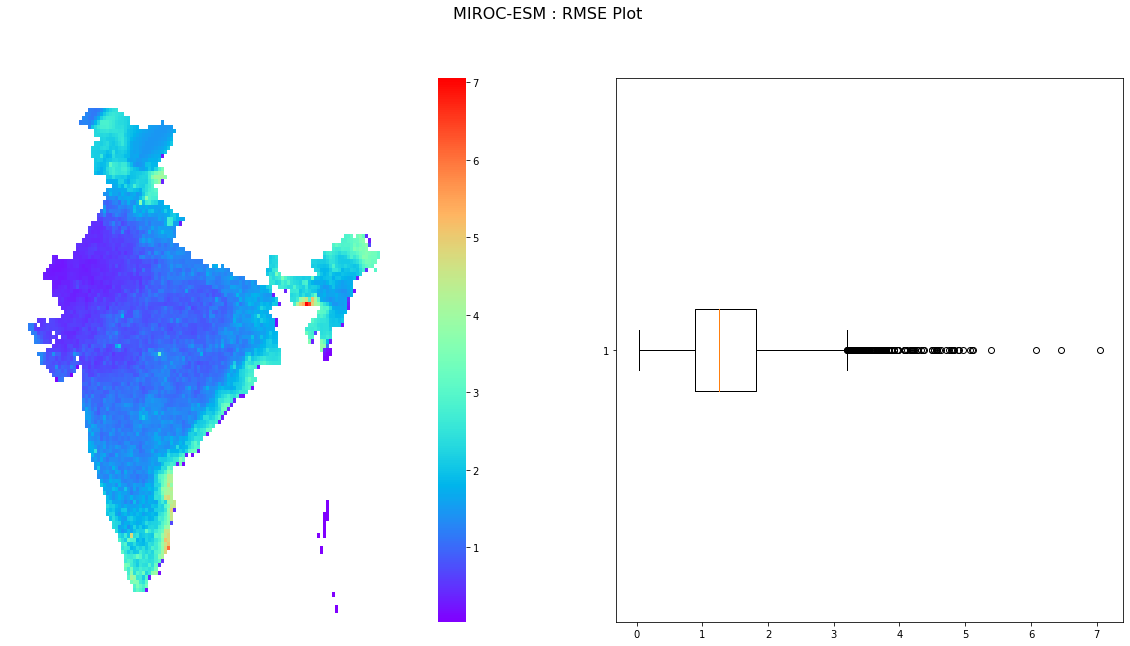

: 

In [15]:
get_RMSE('MIROC-ESM', 'non_monsoon', 'Y_non_monsoon')